In [92]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [93]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        
        #print(type(thetas))
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas]) 
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        # result type is result, so we have to convert to dictionary.. 
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [94]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor(np.asarray([expectation_z]))
        ctx.save_for_backward(input, result)
    
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)  
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [95]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        #xy = np.loadtxt('/Users/kb/Desktop/train_set/caesar_8_train_250.csv', delimiter=',', dtype=np.float32)
        xy = np.loadtxt('/Users/kb/Desktop/train_set_150/caesar_8_train_150.csv', delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, 1:17])
        self.y_data = torch.from_numpy(xy[:, 0])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=1,
                          shuffle=True)

In [96]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(1, 6, kernel_size=1)
        #self.conv2 = nn.Conv2d(6, 16, kernel_size=1)
        self.input = nn.Linear(16, 64)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)
        #print(x)
        return torch.cat((x, 1 - x), -1)  #torch.cat((x, 1 - x), -1)


In [122]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.NLLLoss()


epochs = 20
loss_list = []
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        target = target.long()
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/Users/kb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training [5%]	Loss: 0.7009
Training [10%]	Loss: 0.6988
Training [15%]	Loss: 0.6887
Training [20%]	Loss: 0.6784
Training [25%]	Loss: 0.6703
Training [30%]	Loss: 0.6491
Training [35%]	Loss: 0.5994
Training [40%]	Loss: 0.5752
Training [45%]	Loss: 0.5489
Training [50%]	Loss: 0.5375
Training [55%]	Loss: 0.5566
Training [60%]	Loss: 0.4929
Training [65%]	Loss: 0.4886
Training [70%]	Loss: 0.4913
Training [75%]	Loss: 0.4592
Training [80%]	Loss: 0.4491
Training [85%]	Loss: 0.4652
Training [90%]	Loss: 0.4592
Training [95%]	Loss: 0.4802
Training [100%]	Loss: 0.4407


Text(0, 0.5, 'Neg Log Likelihood Loss')

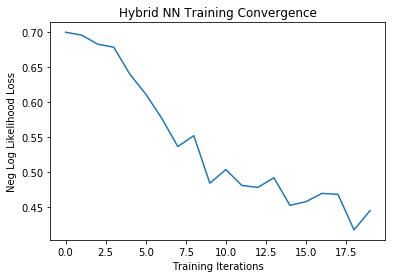

In [113]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [114]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/Users/kb/Desktop/test_set/caesar_8_test_50.csv',
                        delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, 1:17])
        self.y_data = torch.from_numpy(xy[:, 0])
        #self.y_data = self.y_data.reshape(-1,1)
        #self.x_data = self.x_data.reshape(500,1,4)  # 차원 맞추려고

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=1,
                          shuffle=True)

In [121]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        target = target.long()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.5240
	Accuracy: 72.0%
